In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from run_evolution import folder_evol
from analytical_results import fT00, fT01, fT11, fj0, fj1, fnu, fLn
from ploting import plot_heatmaps

In [2]:
g = 1
v, Q = 1, 1
tol, method = 1e-6, '12site'
D0, D = 256, 256
#
ms = [0, 0.1, 0.2, 0.318309886, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5, 2.0]  # [ 1.1, 1.2, 1.5, 2.0] #
# ms = [0.7]
mg = [g * x for x in ms]
Nadt = [(512, 0.125, 1/16)]
NaDdt = [(512, 0.125, 256, 1/16), (512, 0.125, 512, 1/16), (512, 0.125, 1024, 1/16)]
# NaDdt = [ (512, 0.125, 512, 1/16), (512, 0.125, 512, 1/32), (1024, 0.0625, 256, 1/16)] #, (1024, 0.0625, 2, 1/16)]
# (512, 0.125, 256, 1/16),
data = {}

for m in ms:
    for N, a, D, dt in NaDdt:
        D0 = D
        try:
            folder = folder_evol(g, m, a, N, v, Q, D0, dt, D, tol, method, mkdir=False)
            data[m, N, a, dt] = np.load(folder / f"results.npy", allow_pickle=True).item()
        except FileNotFoundError:
            pass

In [3]:
NUM_COLORS = 15
cm = plt.get_cmap('gist_rainbow')
colors = [cm(i / NUM_COLORS) for i in range(NUM_COLORS)]
lines = ['-', '--', '-']

In [4]:
def get_tsm(signals, ev):
    tm = signals["time"]
    mask = tm > -1
    tm = tm[mask]
    ee = signals[ev][mask]
    ee = ee - ee[0, :]
    ee = (ee[:, 0::2] + ee[:, 1::2]) / 2  # average over 2*n and 2*n+1
    mid = (ee[:, N//4] +ee[:, N//4-1])/2
    return tm, ee, mid


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


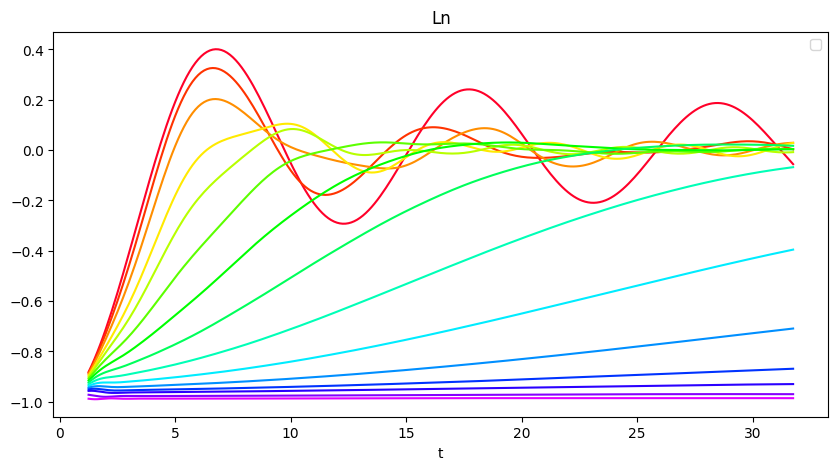

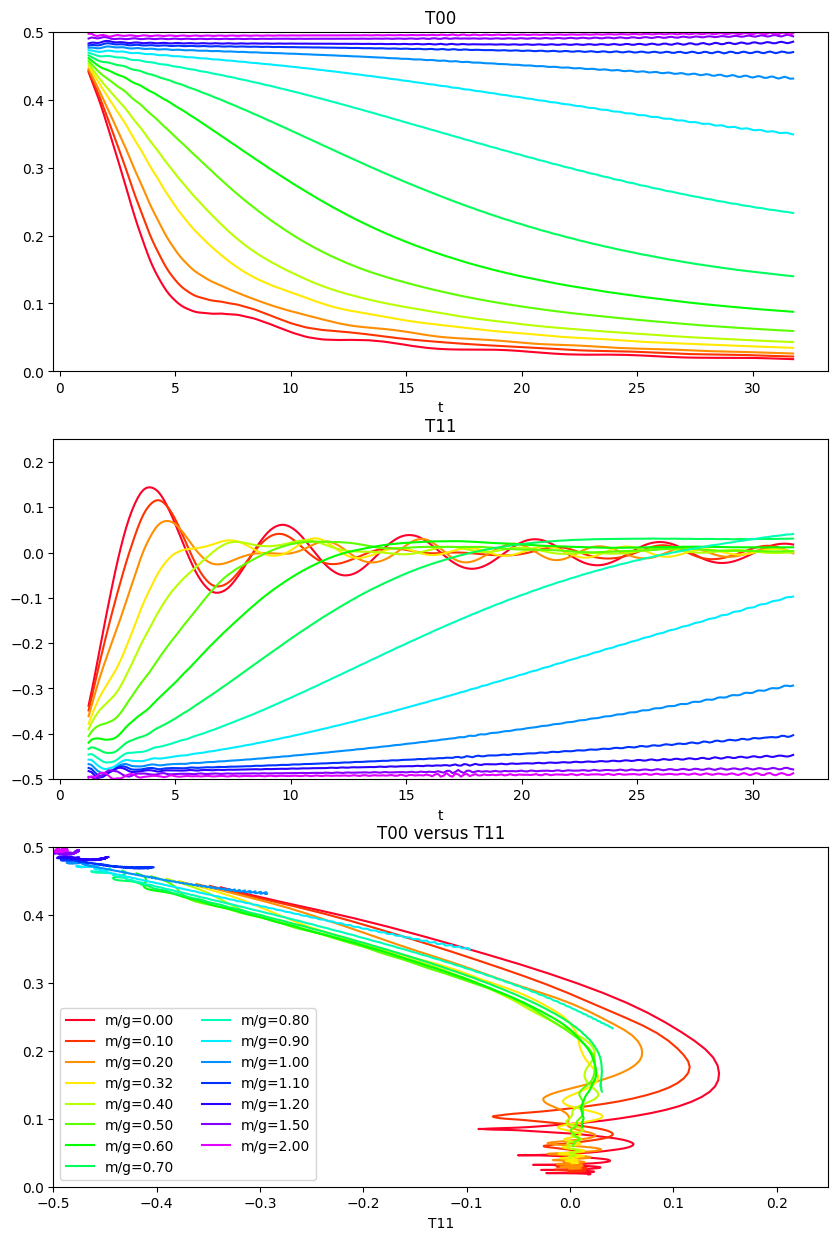

In [5]:
plt.figure(figsize=(10, 5))



for j, (N, a, dt) in enumerate(Nadt):
    for i, m in enumerate(ms):
        tm, ee, mid = get_tsm(data[m, N, a, dt], 'Ln')
        line, = plt.plot(tm[10:-2], mid[10:-2], lines[j], color=colors[i])
        if j == 2:
            line.set_label(f'{m/g=:.2f}')

plt.legend()
plt.xlabel('t')
plt.title('Ln')

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

for j, (N, a, dt) in enumerate(Nadt):
    for i, m in enumerate(ms):
        tm, ee, midE = get_tsm(data[m, N, a, dt], 'T00')
        tm, ee, midp = get_tsm(data[m, N, a, dt], 'T11')
        ax[0].plot(tm[10:-2], midE[10:-2], lines[j], color=colors[i], label=f'{m/g=:.2f}')
        ax[1].plot(tm[10:-2], midp[10:-2], lines[j], color=colors[i], label=f'{m/g=:.2f}')
        ax[2].plot(midp[10:-2], midE[10:-2], lines[j], color=colors[i], label=f'{m/g=:.2f}')

ax[0].set_title('T00')
ax[1].set_title('T11')
ax[2].set_title('T00 versus T11')

ax[0].set_xlabel('t')
ax[1].set_xlabel('t')
ax[2].set_xlabel('T11')

ax[0].set_ylim([0, 0.5])
ax[1].set_ylim([-0.5, 0.25])
ax[2].set_xlim([-0.5, 0.25])
ax[2].set_ylim([0, 0.5])



ax[2].legend(ncols=2)


In [14]:
# test energy from MPO vs T00
for i, m in enumerate(ms):
    for j, (N, a, dt) in enumerate(Nadt):
        mask = data[m, N, a, dt]["time"] > -1  # when some points not calculated yet
        x1 = np.sum(data[m, N, a, dt]["T00"][mask, :], axis=1) * a
        x2 = data[m, N, a, dt]["energy"][mask]
        assert np.max(np.abs((np.abs(1 - x1 / x2) ))) < 1e-8

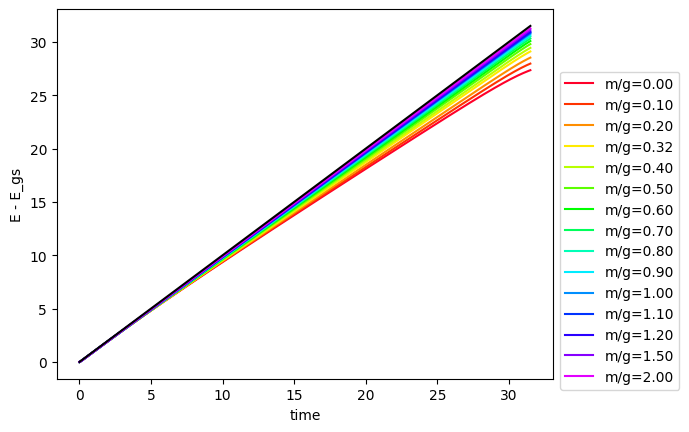

In [15]:
for i, m in enumerate(ms):
    for j, (N, a, dt) in enumerate(Nadt):
        tm = data[m, N, a, dt]["time"]
        mask = tm > -1
        tm = tm[mask]
        en = data[m, N, a, dt]["energy"][mask]
        line, = plt.plot(tm[:-4], en[:-4] - en[0], lines[j], color=colors[i],)
        if j == 0:
            line.set_label(f"{m/g=:0.2f}")

plt.plot(tm[:-4], tm[:-4], '-k')

plt.xlabel('time')
plt.ylabel('E - E_gs')
plt.legend(ncols=1, bbox_to_anchor=(1, 0.85))

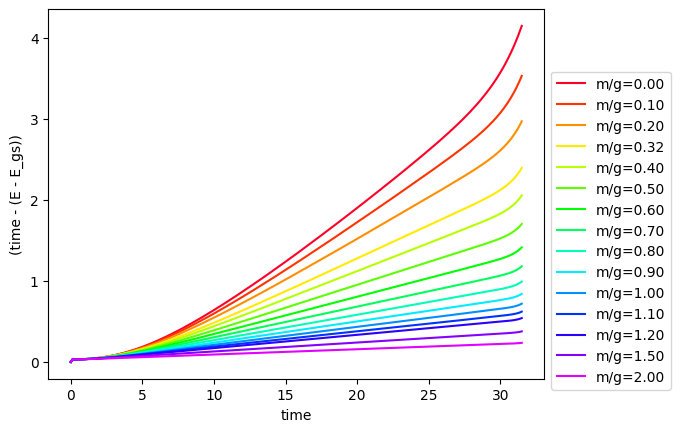

In [18]:
for i, m in enumerate(ms):
    for j, (N, a, dt) in enumerate(Nadt):
        tm = data[m, N, a, dt]["time"]
        mask = tm > -1
        tm = tm[mask]
        en = data[m, N, a, dt]["energy"][mask]
        line, = plt.plot(tm[:-4], (tm[:-4] - (en[:-4] - en[0])), lines[j], color=colors[i],)
        if j == 0:
            line.set_label(f"{m/g=:0.2f}")

plt.xlabel('time')
plt.ylabel('(time - (E - E_gs))')
plt.legend(ncols=1, bbox_to_anchor=(1, 0.85))

In [29]:
NaDdt

[(512, 0.125, 512, 0.0625),
 (512, 0.125, 512, 0.03125),
 (1024, 0.0625, 256, 0.0625)]

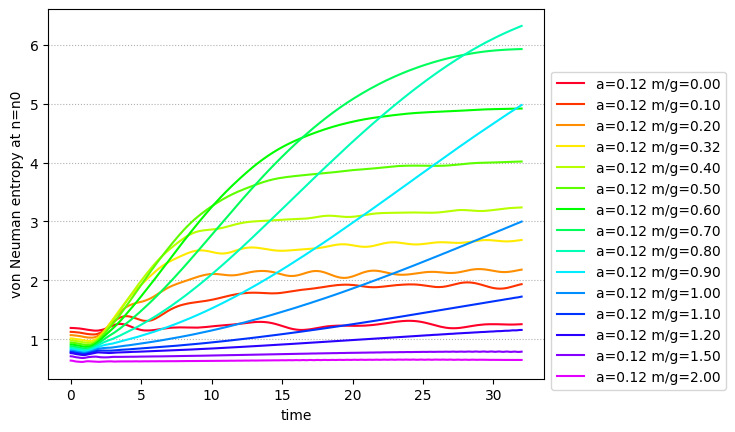

In [20]:
for j, (N, a, dt) in enumerate(Nadt):
    for i, m in enumerate(ms):
        tm = data[m, N, a, dt]["time"]
        mask = tm > -1
        tm = tm[mask]

        ee = data[m, N, a, dt]["entropy_1"][mask]
        # ee = ee - ee[0]

        line, = plt.plot(tm, ee[:, N // 2] , lines[j], color=colors[i])
        if j == 0:
            line.set_label(f"{a=:0.2f} {m/g=:0.2f}")

plt.grid(axis="y", linestyle=':')

plt.xlabel('time')
plt.ylabel('von Neuman entropy at n=n0')
plt.legend(ncols=1, bbox_to_anchor=(1, 0.85))

von Neuman entropy between left and right parts of the lattice; We subtract values in the initial state.

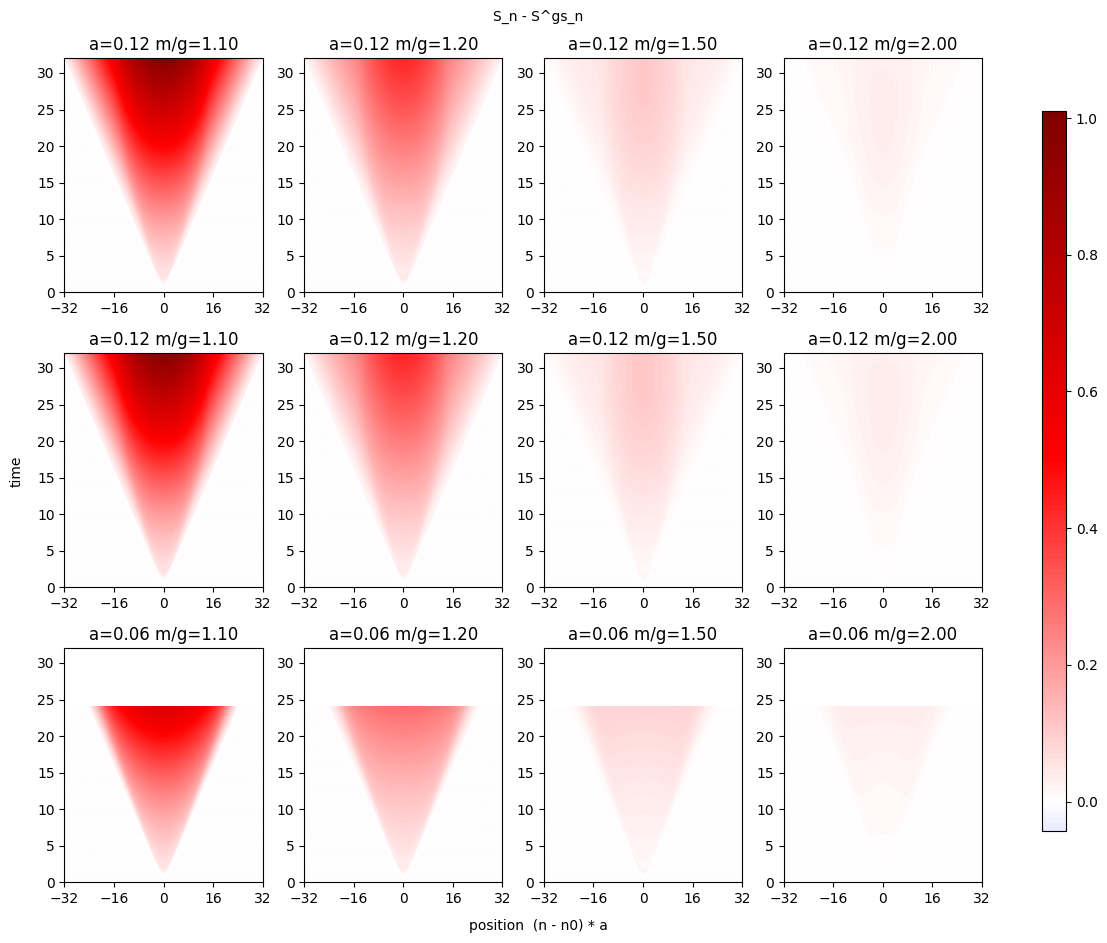

In [31]:
plot_heatmaps('entropy_1', 'S_n - S^gs_n', data, NaDdt, ms, g, subtract_t0=True, avarage_nn=False)

T00 - T00(t=0);  We might avarage over [2*l, 2*l+1] sites.


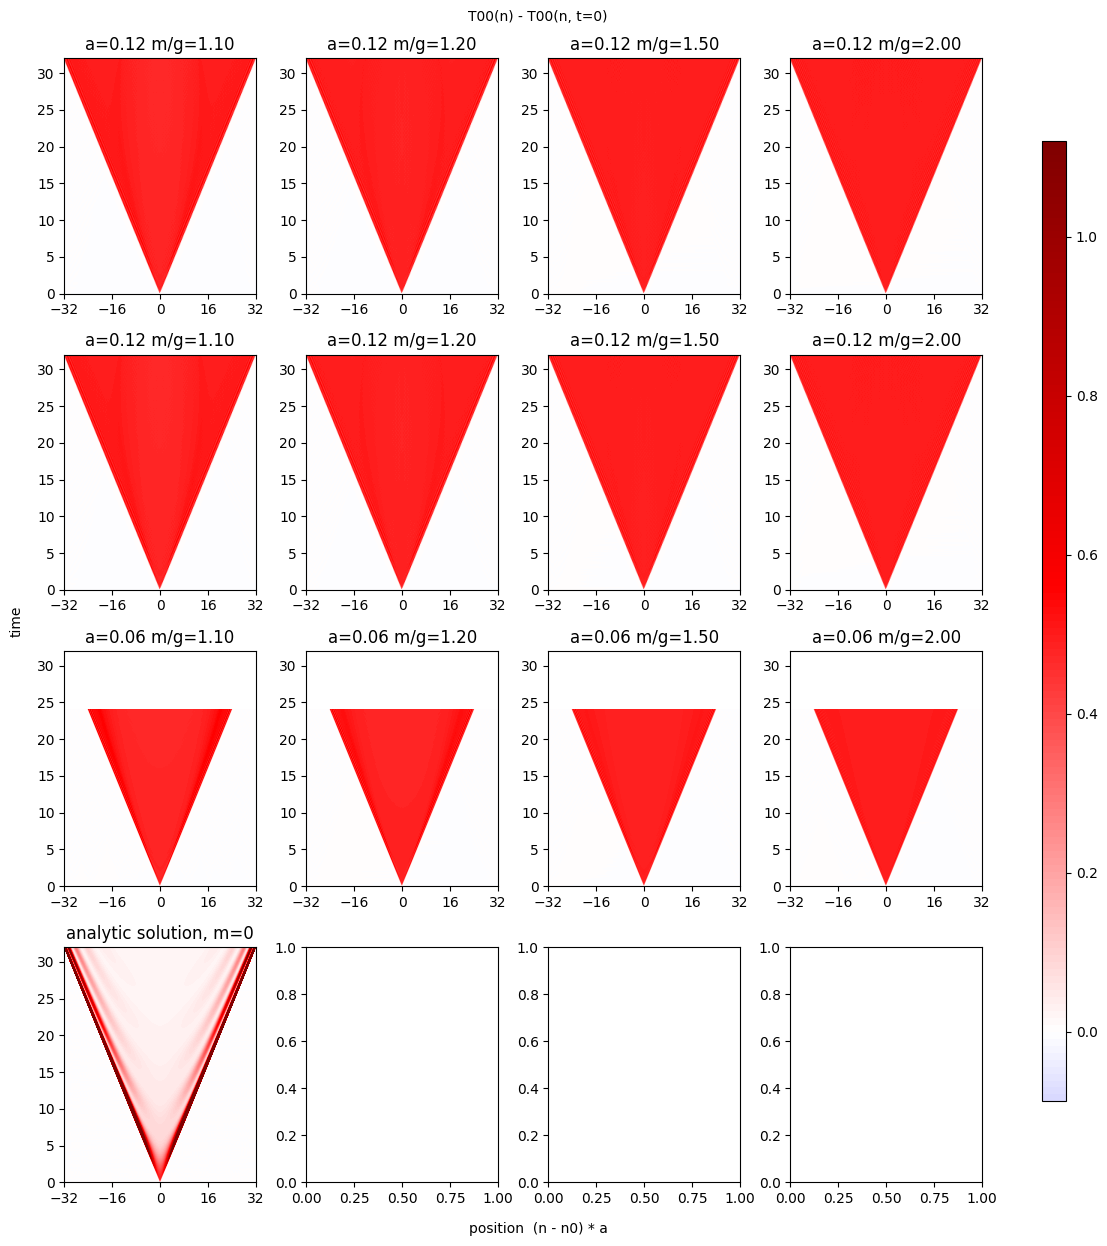

In [32]:
plot_heatmaps("T00", 'T00(n) - T00(n, t=0)', data, NaDdt, ms, g, fT00, subtract_t0=True, avarage_nn=True)

T11; We avarage over [2*l, 2*l+1] sites, and subtract initial value.

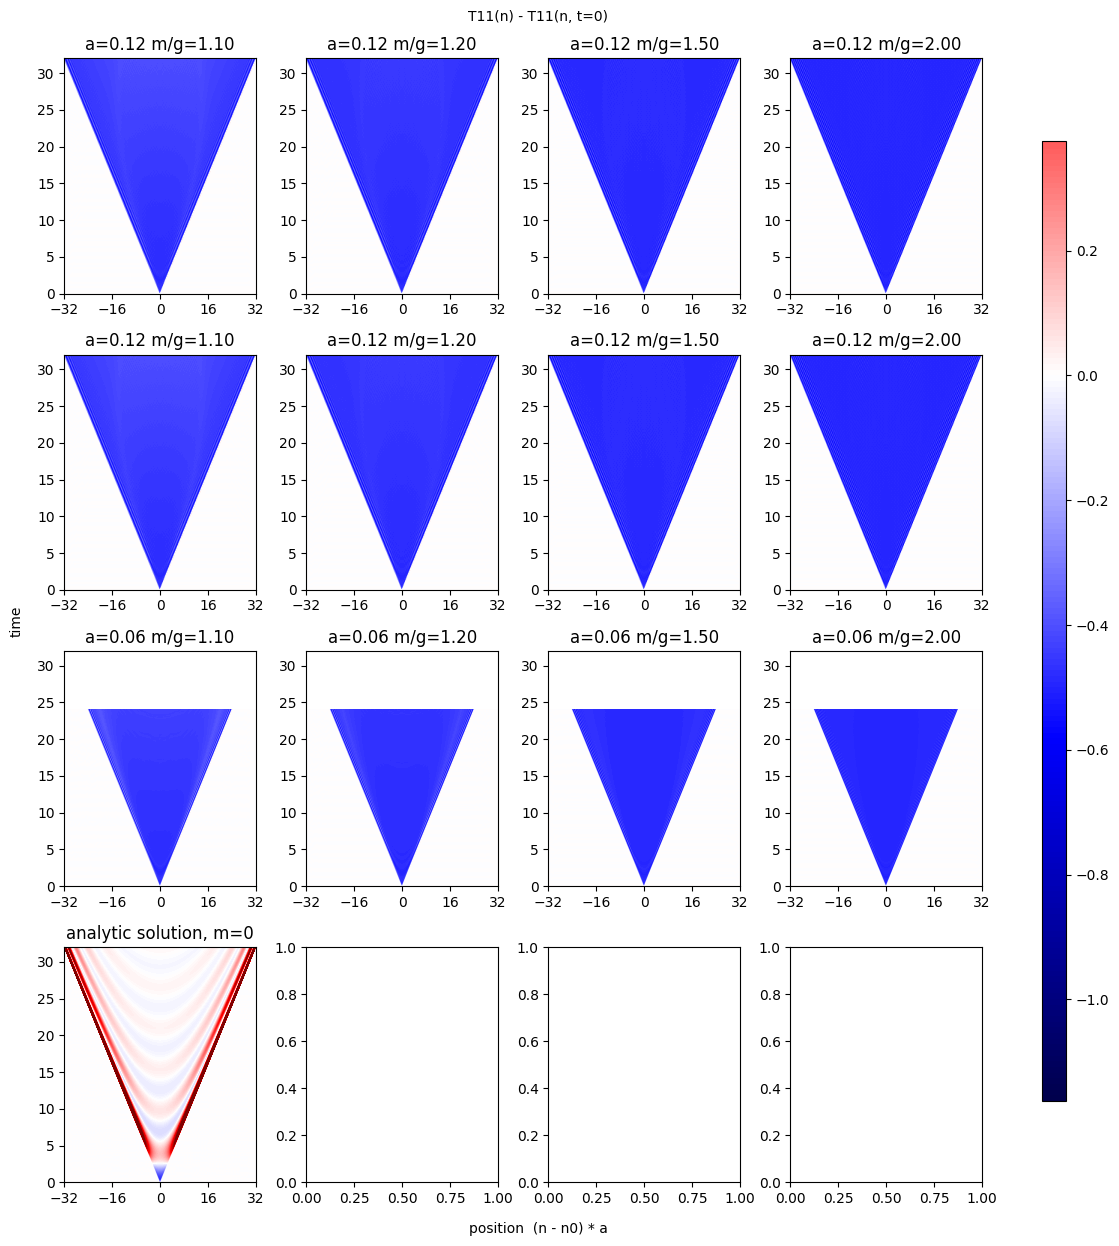

In [33]:
plot_heatmaps("T11", 'T11(n) - T11(n, t=0)', data, NaDdt, ms, g, fT11, subtract_t0=True, avarage_nn=True)

T01 - T01(t=0); We can avarage over [2*l, 2*l+1] sites.

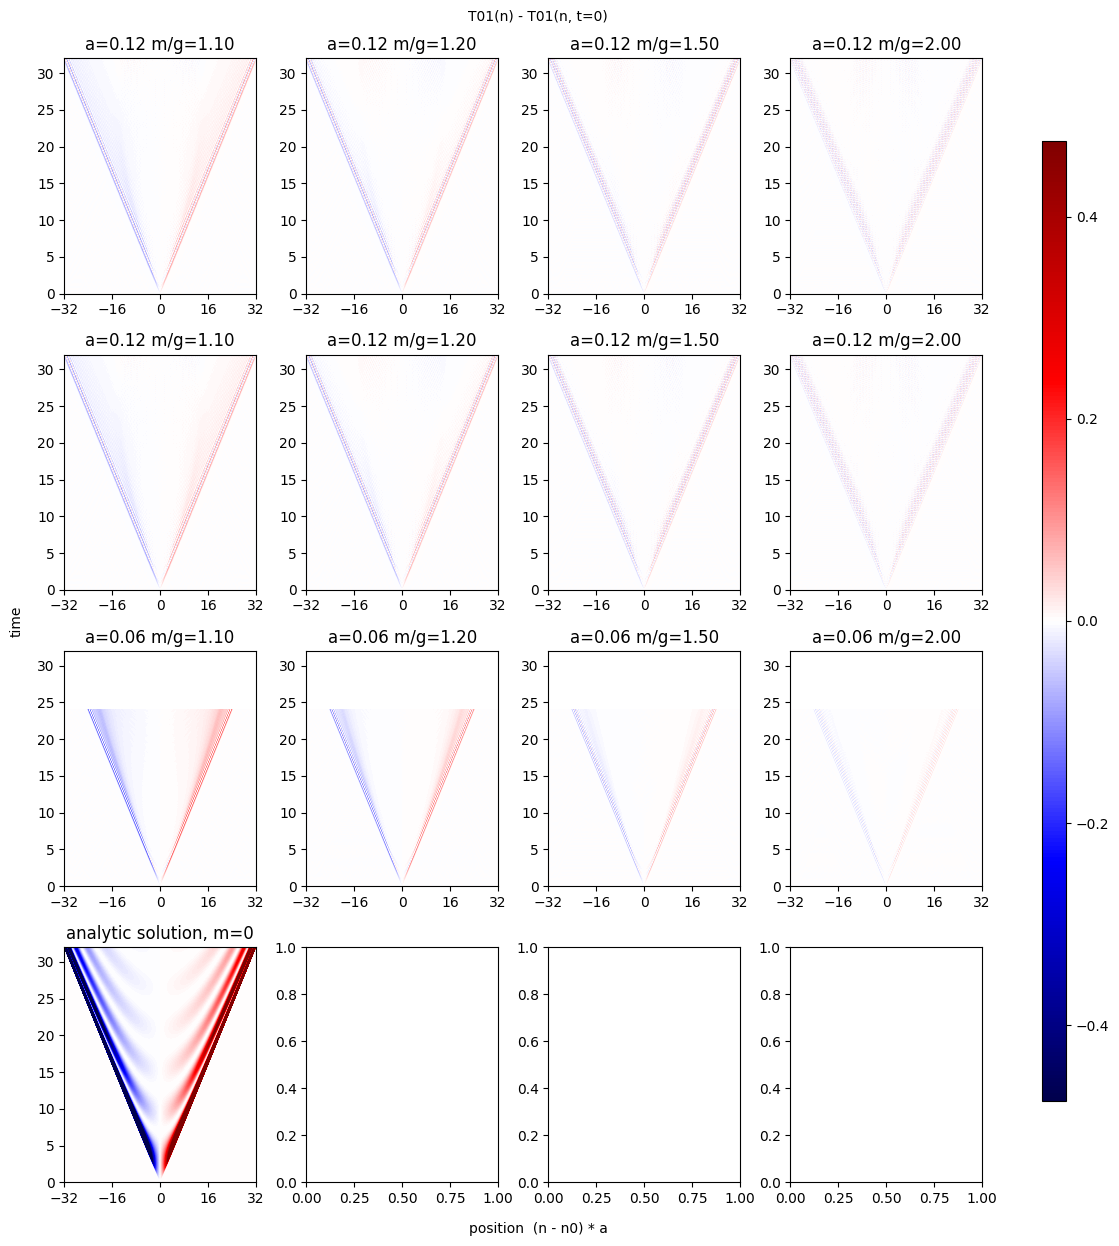

In [34]:
plot_heatmaps("T01", 'T01(n) - T01(n, t=0)', data, NaDdt, ms, g, fT01, subtract_t0=True, avarage_nn=True)

j0; subtract j0(t=0)

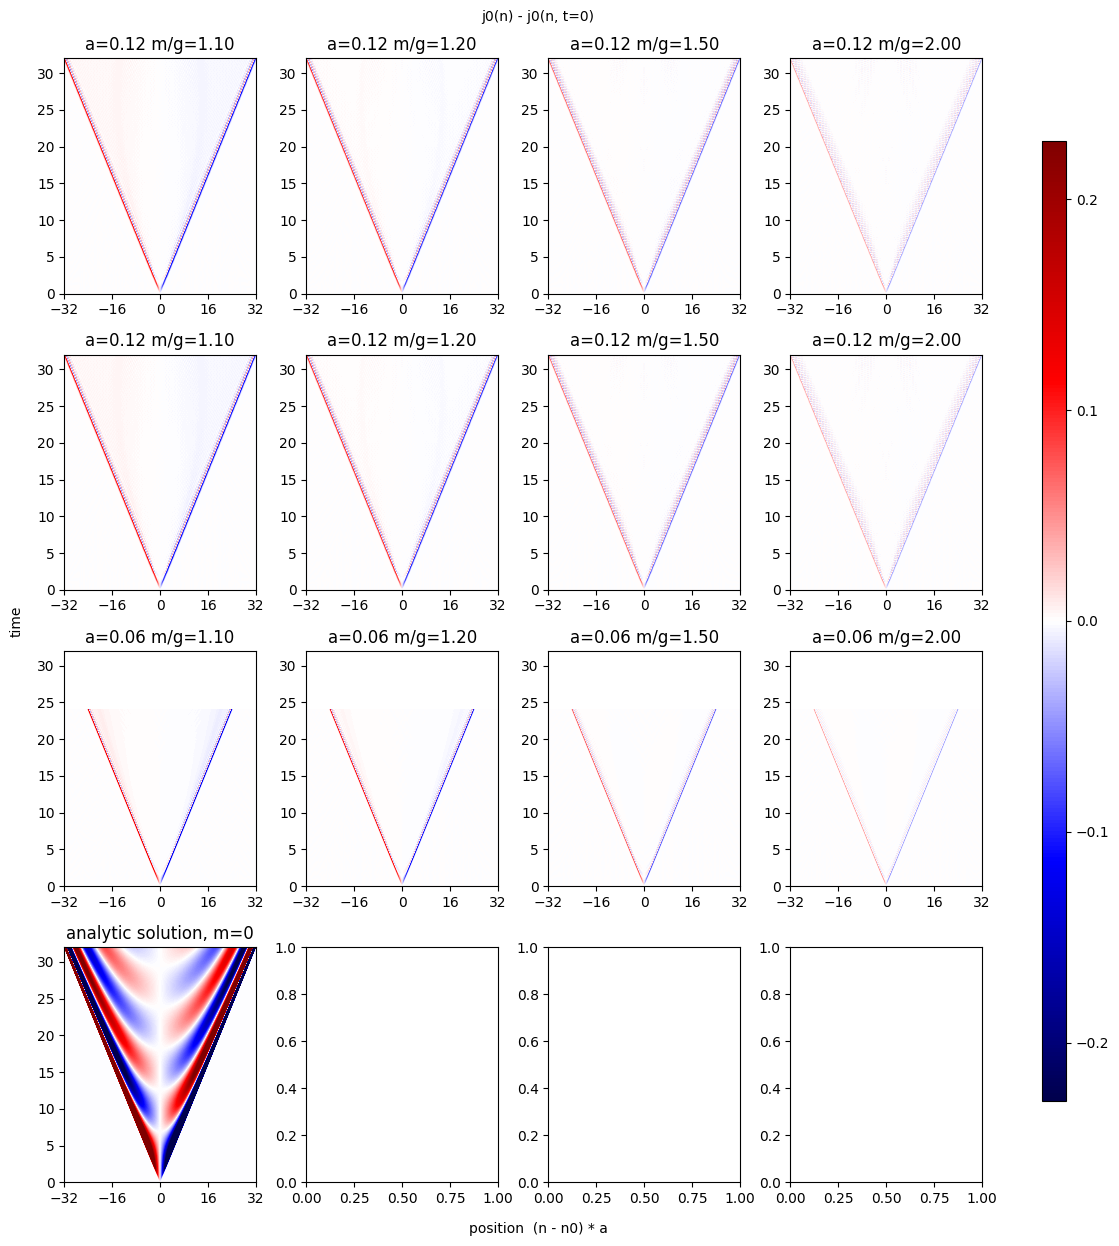

In [35]:
plot_heatmaps("j0", 'j0(n) - j0(n, t=0)', data, NaDdt, ms, g, fj0, subtract_t0=True, avarage_nn=False)

j1;

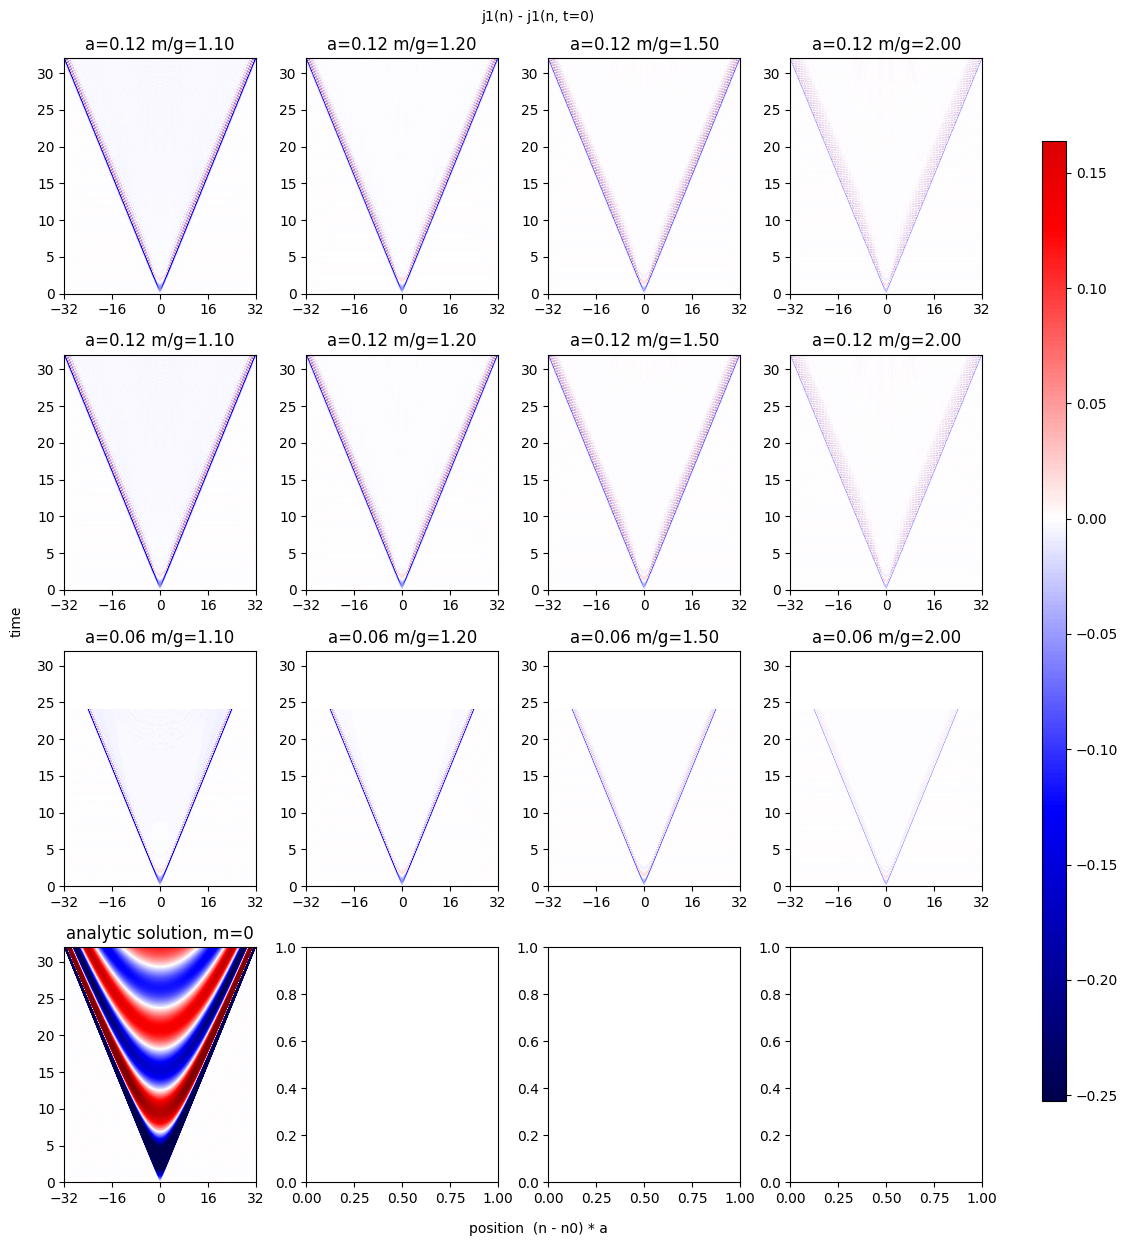

In [36]:
plot_heatmaps("j1", 'j1(n) - j1(n, t=0)', data, NaDdt, ms, g, fj1, subtract_t0=True, avarage_nn=False)

condensate

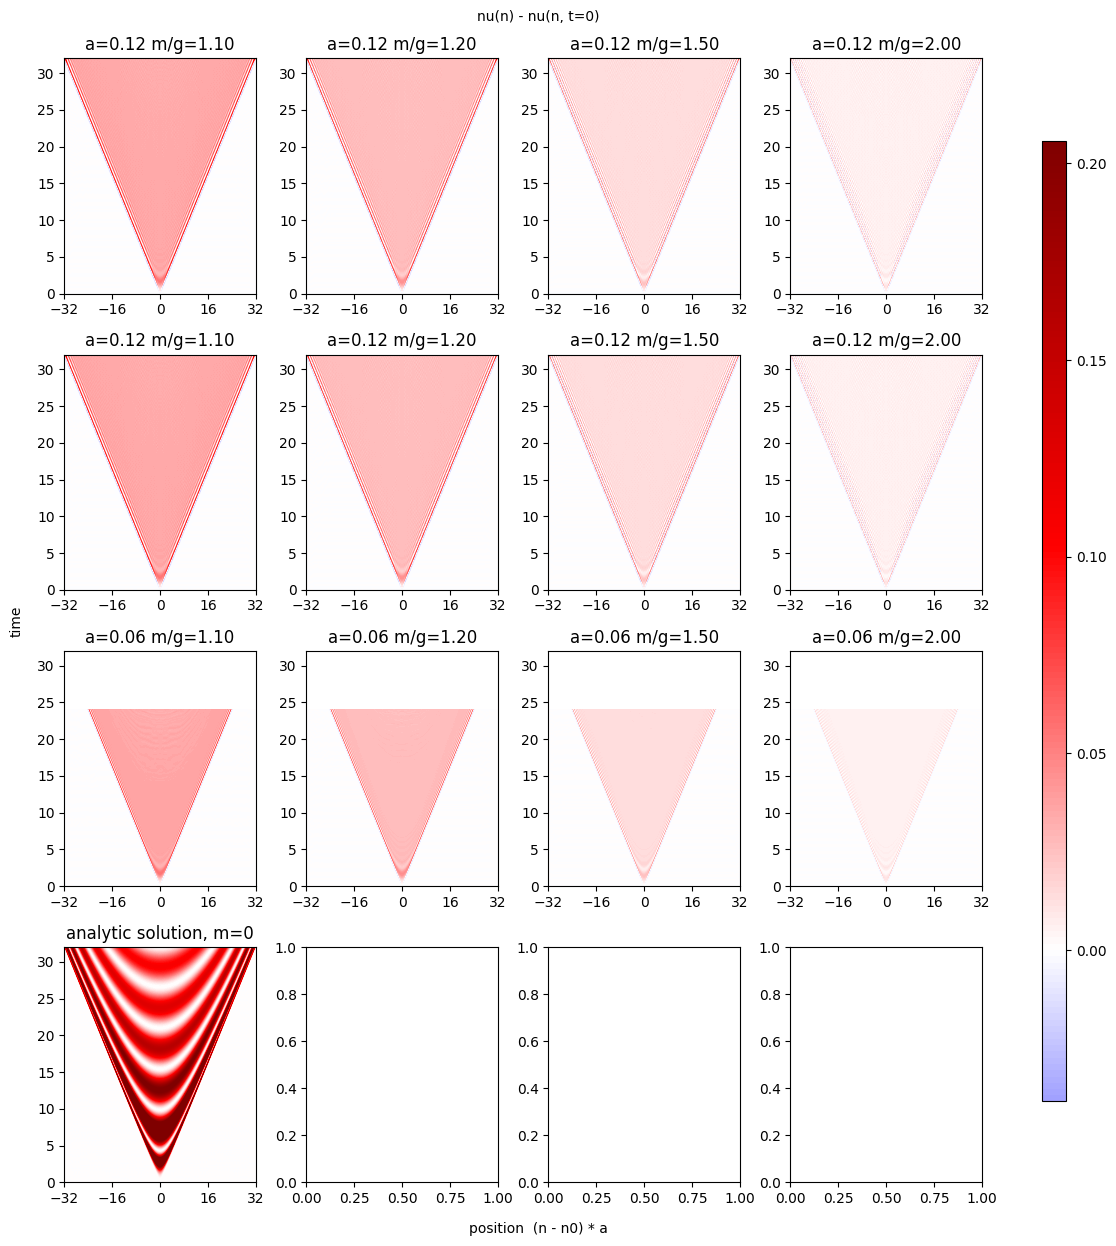

In [37]:
plot_heatmaps("nu", 'nu(n) - nu(n, t=0)', data, NaDdt, ms, g, fnu, subtract_t0=True, avarage_nn=False)

Ln

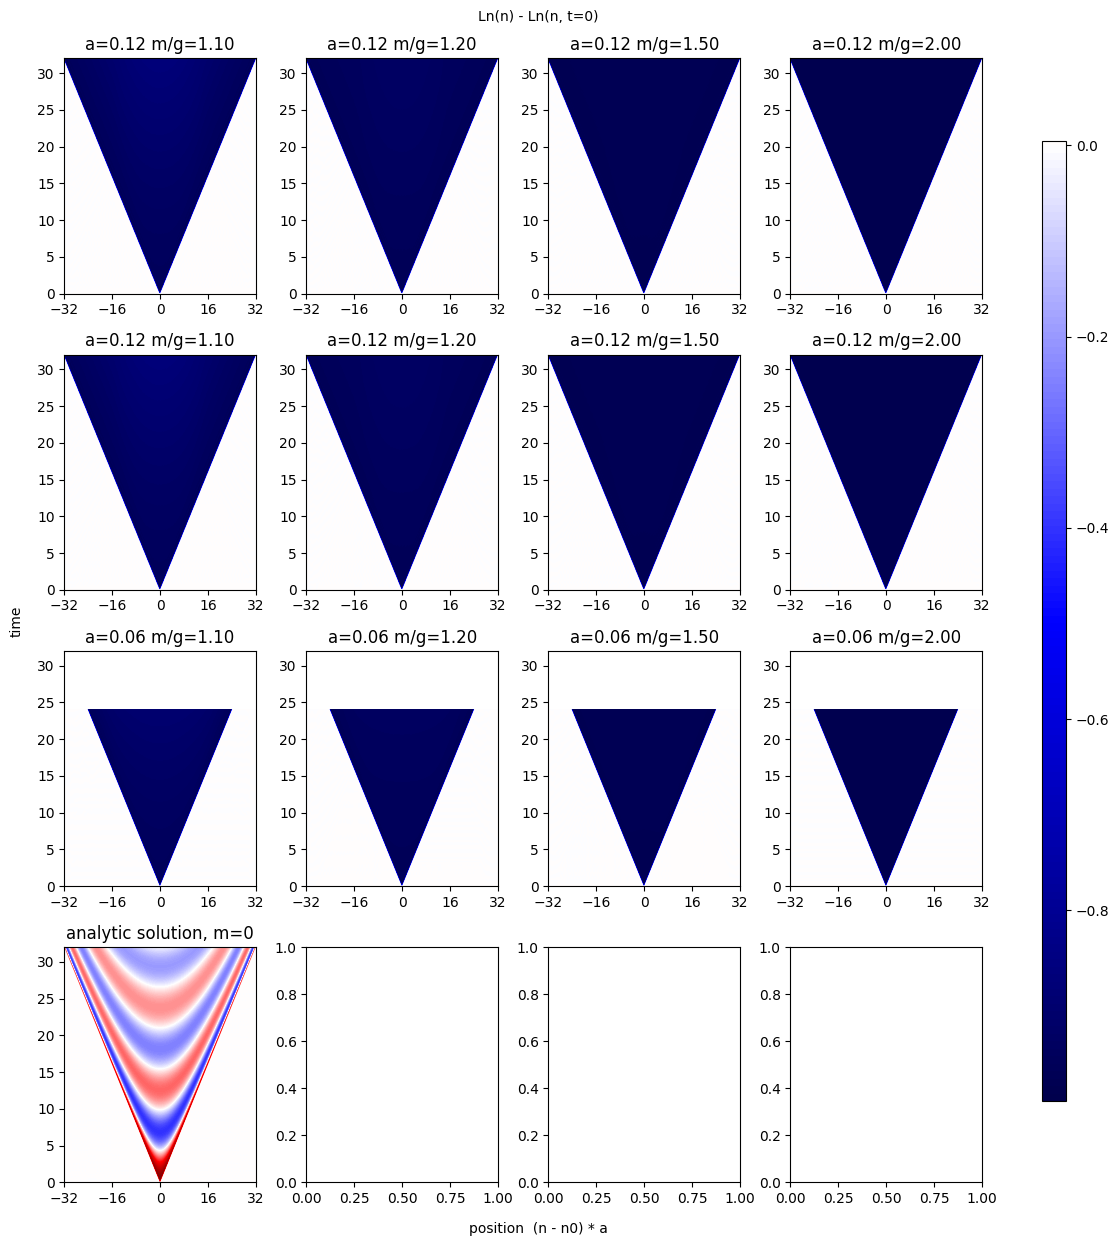

In [38]:
plot_heatmaps("Ln", 'Ln(n) - Ln(n, t=0)', data, NaDdt, ms, g, fLn, subtract_t0=True, avarage_nn=False)

In [39]:
NaDdt = [ (512, 0.125, 1024, 1/16) ]
#
sl = slice(10, -2)
N, a, _, _ = NaDdt[0]
#
plateau = []
plateaumax = []

plt.figure(figsize=(10, 5))

for i, m in enumerate(ms[:-3]):

    tm = data[m, N, a, D, dt]["time"]
    ee = data[m, N, a, D, dt]["entropy_1"]
    eemid = ee[:, N // 2] - ee[0, N // 2]
    plateau.append(eemid[-1])
    # plateaumax.append(np.amax(eemid))

    plt.plot(tm, eemid, label='m/g={:.2f}'.format(m/g))

plt.legend()
plt.xlabel('t')
plt.title('entropy')

plateau = np.array(plateau)
# plateaumax = np.array(plateaumax)

for mgg, e in zip(mg[:-3], plateau):
    print('{',mgg,',',e,'}, ', end='')
print()
print()
# for mgg, e in zip(mg[:-3], plateaumax):
#     print('{',mgg,',',e,'}, ', end='')
# print()


x = np.linspace(0, 0.75, 100)

plt.figure()
plt.plot(mg[:-3], plateau, 'o', alpha=0.5)
#plt.plot(mg[:-3], plateaumax, 'o', alpha=0.5)
plt.plot(x, 0.54 + 1.81 * x +5.46*x**2, label=r'$0.54 + 1.81\,x +5.46\,x^2$')
plt.plot(x, 5.95*x, label=r'$5.95\,x$')


plt.xlabel('m/g')
plt.ylabel('entanglement entropy plateau')
plt.legend()


plt.figure()

for i, m in enumerate(ms):

    tm = data[m, N, a, D, dt]["time"]
    ee = data[m, N, a, D, dt]["entropy_1"]
    eemid = ee[:, N // 2] - ee[0, N // 2]

    _, _, midE = get_tsm(data[m, N, a, D, dt], 'T00')

    if m>0:
        eemid = eemid/(0.54 + 1.81 * m +5.46*m**2)

    plt.plot(tm , eemid, label='m/g={:.2f}'.format(m/g))


plt.legend()
plt.xlabel('t')
plt.ylabel('rescaled entropy')

plt.show()


KeyError: (1.1, 512, 0.125, 256, 0.0625)

<Figure size 1000x500 with 0 Axes>